### Description

This notebooks collects the datasets downloaded from the ClinVar webpage (https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/) into one dataset to retrive the changed labels (notebook 1.ClinVar Analysis)


In [1]:
import pandas as pd
import os
from glob import glob
os.chdir('/fast/groups/ag_kircher/work/MisLa/MisLaReview')# run only once, or change to hard coded path

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', None)

import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import numpy as np

In [2]:
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import numpy as np
import sys
os.chdir('/fast/groups/ag_kircher/work/MisLa/MisLaReview/scripts')# run only once, or change to hard coded path
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', None)


sys.path.insert(0,'scripts/')
from utilsClinVar import *
import matplotlib.style
import matplotlib as mpl
#mpl.style.use('classic')
#mpl.rcParams['image.cmap'] = 'jet'
os.chdir('/fast/groups/ag_kircher/work/MisLa/MisLaReview')# run only once, or change to hard coded path


ModuleNotFoundError: No module named 'utilsClinVar'

###

In [4]:
######## SAVE IN SCRIPT createClinVarOldNewLabels #########
## no need to run

# not all years have data for all months
years = [2015,2016,2017,2018,2019,2020,2021,2022,2023]  
# the ClinicalSignificance columns has various classes, take only these to avoid ambiguity 
classes = ['Uncertain significance', 'Likely benign', 'Benign', 'Conflicting interpretations of pathogenicity', 
           'Pathogenic', 'Likely pathogenic', 'Benign/Likely benign', 'Pathogenic/Likely pathogenic']



to_replace = {'Uncertain significance': 'VUS', 
              'Conflicting interpretations':'Conflicting',
              'Conflicting interpretations of pathogenicity':'Conflicting',
             'Pathogenic/Likely pathogenic': 'Pathogenic',
             'Likely pathogenic' :'Pathogenic',
             'Benign/Likely benign' : 'Benign',
             'Likely benign' :'Benign'}

CHR = pd.Series(list(range(1,23))+['X','Y']).astype(str)
sample = True
#years = [2015]   
#years = [2015,2016,2017,2018,2019,2020]  

dates = []
di = {'Ref': ['ReferenceAllele', 'ReferenceAlleleVCF'],
                 'Alt' : ['AlternateAllele', 'AlternateAlleleVCF' ]}
allYears = pd.DataFrame()
for year in years:
    y = str(year)
    print(year)
    files = pd.Series(glob('../dataRaw/ClinVar/'+y+'/*')).sort_values()[:]
    for file in files:
        df_temp = pd.read_csv(file,sep = '\t',low_memory=False, na_values = ['na'])
        
        # some months in 2015 does not have any allele column: ignore them 
        if not sum(df_temp.columns.str.contains('ReferenceAllele')):
            print(file)
            pass 
        else:
            
            d = file.split('_')[2].split('.')[0]
            dates.append(d)
            
           

           # df_temp = df_temp[df_temp['Type']=='single nucleotide variant']
          #  df_temp = df_temp[df_temp['Type'].isin(['single nucleotide variant', 'Deletion', 
       #'Microsatellite', 'Indel', 'Insertion', 'Variation'])]
        
       
            df_temp = df_temp[df_temp['Assembly']=='GRCh38']
            df_temp = df_temp[df_temp['ClinicalSignificance'].isin(classes)]
            
           
            
            for key in di.keys():
            
                df_temp[key] = df_temp[di[key][0]]
                
                ind = df_temp[df_temp[key].isna()].index
                # from end of 2020, the ReferenceAllele and AlternateAllele are not used anymore
                # but columns ReferenceAlleleVCF and AlternateAlleleVCF
                if sum(df_temp.columns.str.contains(di[key][1])):

                    df_temp.loc[ind, key] = df_temp.loc[ind, di[key][1]]
                    
            s = len(df_temp)

            cols = ['Chromosome', 'Start', 'Ref', 'Alt']
            df_temp = df_temp.dropna(subset = cols, how = 'any')
            
            if sample:
                df_temp = df_temp[((df_temp['Ref'].str.len()<=50)&(df_temp['Alt'].str.len()<=50))]
                df_temp = df_temp[df_temp['Type'].isin(['single nucleotide variant', 'Deletion', 
               'Indel', 'Insertion'])]
            
        #    df_temp = df_temp[((df_temp['Ref'].isin(['A', 'T', 'C', 'G']))&(df_temp['Alt'].isin(['A', 'T', 'C', 'G'])))]
            
            df_temp = df_temp[df_temp['Chromosome'].astype(str).isin(CHR)]
            df_temp['Start'] = df_temp['Start'].astype(int)

            df_temp = df_temp.drop_duplicates(cols)
           # print('{}: Length of the joint file is : {}, {} less than the original'.format(d,len(df_temp),s-len(df_temp)))
            df_temp = df_temp.set_index(cols, drop = False)
           # print(df_temp['Type'].unique())
            df_temp['ClinicalSignificance'] = df_temp['ClinicalSignificance'].replace(to_replace)
            allYears = pd.concat([allYears, df_temp['ClinicalSignificance']],axis = 1, join = 'outer')
            ch= 0
            if allYears.shape[1]>1:
                temp = allYears[~allYears.iloc[:,-1].isna()&~allYears.iloc[:,-2].isna()]

                ch = temp[temp.iloc[:,-1]!=temp.iloc[:,-2]].shape[0]
                print('{}: Length of the joint file is : {}, {} less than the original. {} variants changed their label'\
                      .format(d,len(df_temp),s-len(df_temp),ch))

            

allYears.columns = dates
# unique keeps the order of the labels occurance
uniqueLabels = allYears.T.apply(lambda x: x.dropna().unique())
allYears['uniqueLabels'] = uniqueLabels
allYears['LabelOld'] = allYears['uniqueLabels'].str[0]
allYears['LabelNew'] = allYears['uniqueLabels'].str[-1]
labels = ['LabelOld', 'LabelNew']



allYears[labels] = allYears[labels].replace(to_replace)



changed = (allYears['LabelOld']!=allYears['LabelNew']).sum()
print('The final file has {} entries. {} variants changed their clinical interpretation.'.format(len(allYears),changed ))



#allYears.to_csv('dataProduced/ClinVarAllLabels.csv.gz',index = True, header = True,
#                sep='\t', compression = 'zip' )

#allYears.to_csv('dataProduced/ClinVarTwoLabels.csv.gz',index = True, header = True,
#                sep='\t', compression = 'zip' )

2015
../dataRaw/ClinVar/2015/variant_summary_2015-02.txt.gz
../dataRaw/ClinVar/2015/variant_summary_2015-03.txt.gz
../dataRaw/ClinVar/2015/variant_summary_2015-04.txt.gz
2015-06: Length of the joint file is : 81443, 24264 less than the original. 7 variants changed their label
2015-07: Length of the joint file is : 82099, 24343 less than the original. 1 variants changed their label
2015-08: Length of the joint file is : 67050, 25534 less than the original. 63 variants changed their label
2015-09: Length of the joint file is : 70297, 25907 less than the original. 2 variants changed their label
2015-10: Length of the joint file is : 71322, 26139 less than the original. 1 variants changed their label
2015-11: Length of the joint file is : 77267, 27355 less than the original. 78 variants changed their label
2015-12: Length of the joint file is : 77657, 27518 less than the original. 4 variants changed their label
2016
2016-01: Length of the joint file is : 78453, 27602 less than the original

2021-07: Length of the joint file is : 905122, 57377 less than the original. 3264 variants changed their label
2021-08: Length of the joint file is : 914238, 58279 less than the original. 539 variants changed their label
2021-09: Length of the joint file is : 937843, 60064 less than the original. 1049 variants changed their label
2021-10: Length of the joint file is : 1017316, 68649 less than the original. 3494 variants changed their label
2021-11: Length of the joint file is : 1020627, 68912 less than the original. 423 variants changed their label
2021-12: Length of the joint file is : 1038631, 69439 less than the original. 1312 variants changed their label
2022
2022-01: Length of the joint file is : 1042290, 69677 less than the original. 368 variants changed their label
2022-02: Length of the joint file is : 1050397, 70093 less than the original. 1008 variants changed their label
2022-03: Length of the joint file is : 1052537, 70280 less than the original. 312 variants changed their 

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_2183708/4051590916.py:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allYears['LabelNew'] = allYears['uniqueLabels'].str[-1]


The final file has 2120423 entries. 134197 variants changed their clinical interpretation.


In [155]:
df_temp['ClinicalSignificance'].value_counts()

ClinicalSignificance
Benign                                          577778
VUS                                             565178
Pathogenic                                      155225
Conflicting interpretations of pathogenicity     63814
Benign/Likely benign                             28955
Name: count, dtype: int64

In [147]:
changed = allYears[allYears['LabelOld']!=allYears['LabelNew']]
changed.shape

(175712, 101)

In [148]:
rest = changed[~((changed['LabelOld'].str.contains('Conflicting'))|(changed['LabelNew'].str.contains('Conflicting')))]#.sum()
conf = changed[((changed['LabelOld'].str.contains('Conflicting'))|(changed['LabelNew'].str.contains('Conflicting')))]#.sum()



In [149]:
conf.shape

(101235, 101)

In [145]:
df_temp.head()

#AlleleID   
Chromosome Start     Ref             Alt                                 
7          4781213   GGAT            TGCTGTAAACTGTAACTGTAAA      15041  \
           4787730   GCTGCTGGACCTGCC G                           15042   
15         84799209  G               A                           15043   
11         126275389 C               T                           15044   
           126277517 A               G                           15045   

                                                                                  Type   
Chromosome Start     Ref             Alt                                                 
7          4781213   GGAT            TGCTGTAAACTGTAACTGTAAA                      Indel  \
           4787730   GCTGCTGGACCTGCC G                                        Deletion   
15         84799209  G               A                       single nucleotide variant   
11         126275389 C               T                       single nucleotide variant   
           126277517 A               G                       single nucleotide variant   

                                                                                                                                              Name   
Chromosome Start     Ref             Alt                                                                                                             
7          4781213   GGAT            TGCTGTAAACTGTAACTGTAAA  NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTAACTGTAAA (p.Arg27_Ile28delinsLeuLeuTer)  \
           4787730   GCTGCTGGACCTGCC G                                                              NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs)   
15         84799209  G               A                                                                NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg)   
11         126275389 C               T                                                                 NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter)   
           126277517 A               G                                                                NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser)   

                                                             GeneID   
Chromosome Start     Ref             Alt                              
7          4781213   GGAT            TGCTGTAAACTGTAACTGTAAA    9907  \
           4787730   GCTGCTGGACCTGCC G                         9907   
15         84799209  G               A                         9640   
11         126275389 C               T                        55572   
           126277517 A               G                        55572   

                                                            GeneSymbol   
Chromosome Start     Ref             Alt                                 
7          4781213   GGAT            TGCTGTAAACTGTAACTGTAAA      AP5Z1  \
           4787730   GCTGCTGGACCTGCC G                           AP5Z1   
15         84799209  G               A                          ZNF592   
11         126275389 C               T                         FOXRED1   
           126277517 A               G                         FOXRED1   

                                                                HGNC_ID   
Chromosome Start     Ref             Alt                                  
7          4781213   GGAT            TGCTGTAAACTGTAACTGTAAA  HGNC:22197  \
           4787730   GCTGCTGGACCTGCC G                       HGNC:22197   
15         84799209  G               A                       HGNC:28986   
11         126275389 C               T                       HGNC:26927   
           126277517 A               G                       HGNC:26927   

                                                            ClinicalSignificance   
Chromosome Start     Ref             Alt                                           
7          4781213   GGAT            TGCTGTAAACTGTAACTGTAAA           Pathogenic  \
           4787730   GCTGCTGGACCTGCC G                           

In [131]:


to_replace = {'Uncertain significance': 'VUS', 
              'Conflicting interpretations':'Conflicting',
              'Conflicting interpretations of pathogenicity':'Conflicting',
             'Pathogenic/Likely pathogenic': 'Pathogenic',
             'Likely pathogenic' :'Pathogenic',
             'Benign/Likely benign' : 'Benign',
             'Likely benign' :'Benign',
             'Bengn':'Benign'}
allYears[labels] = allYears[labels].replace(to_replace)


In [132]:
vus = changed[((changed['LabelOld'].str.contains('VUS'))|(changed['LabelNew'].str.contains('VUS')))]#.sum()
a = pd.crosstab(vus['LabelOld'],vus['LabelNew'])


In [136]:
df_temp['ClinicalSignificance'].replace(to_replace)

Chromosome  Start      Ref              Alt                   
7           4781213    GGAT             TGCTGTAAACTGTAACTGTAAA    Pathogenic
            4787730    GCTGCTGGACCTGCC  G                         Pathogenic
15          84799209   G                A                                VUS
11          126275389  C                T                         Pathogenic
            126277517  A                G                         Pathogenic
                                                                     ...    
X           10449553   AG               A                         Pathogenic
9           13222345   G                A                                VUS
13          101292071  A                C                         Pathogenic
17          31225168   C                A                                VUS
14          36517751   T                A                         Pathogenic
Name: ClinicalSignificance, Length: 1494351, dtype: object

In [113]:
pd.crosstab(allYears['LabelOld'],allYears['LabelNew'])

LabelNew,Bengn,Benign,Benign/Likely benign,Conflicting interpretations of pathogenicity,Pathogenic,VUS
LabelOld,,,,,,
Bengn,421784,11378,13977,16629,26,1569
Benign,875,155519,16239,3523,15,141
Benign/Likely benign,127,925,1353,224,0,3
Conflicting interpretations of pathogenicity,182,204,388,2827,231,253
Pathogenic,207,202,150,6504,168022,4187
VUS,6951,2217,2849,43051,2967,642320


In [ ]:
The final file has 1659070 entries. 141099 variants changed their clinical interpretation.

In [34]:
allYears = allYears.reset_index()

In [54]:
df_temp = df_temp[((df_temp['Ref'].str.len()<=50)&(df_temp['Alt'].str.len()<=50))]

(1555185, 36)

In [48]:
df_temp['Type'].value_counts().index

Index(['single nucleotide variant', 'Deletion', 'Duplication',
       'Microsatellite', 'Indel', 'Insertion', 'Inversion', 'Variation',
       'copy number loss', 'copy number gain'],
      dtype='object', name='Type')

In [6]:
changed = allYears[allYears['LabelOld']!=allYears['LabelNew']]

In [7]:
changed = changed.reset_index()

In [11]:
changed['level_3'].str.len().value_counts()

level_3
1    134009
Name: count, dtype: int64

In [13]:
df_temp['Type'].value_counts()

Type
single nucleotide variant    1398339
Variation                        276
Deletion                           3
Duplication                        1
Indel                              1
Name: count, dtype: int64

In [55]:
df = pd.read_csv('dataRaw/ClinVar/2023/variant_summary_2023-01.txt.gz',sep = '\t')
df = df[df['Assembly']=='GRCh38']
df.head()

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_3525720/96681126.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataRaw/ClinVar/2023/variant_summary_2023-01.txt.gz',sep = '\t')


,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),nsv/esv (dbVar),RCVaccession,PhenotypeIDS,PhenotypeList,Origin,OriginSimple,Assembly,ChromosomeAccession,Chromosome,Start,Stop,ReferenceAllele,AlternateAllele,Cytogenetic,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF
0,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTAACTGTAAA (p.Arg27_Ile28delinsLeuLeuTer),9907,AP5Z1,HGNC:22197,Pathogenic,1,-,397704705,-,RCV000000012,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:613647,Orphanet:306511",Hereditary spastic paraplegia 48,germline;unknown,germline,GRCh37,NC_000007.13,7,4820844,4820847,na,na,7p22.1,"criteria provided, single submitter",2,-,N,"ClinGen:CA215070,OMIM:613653.0001",3,2,4820844,GGAT,TGCTGTAAACTGTAACTGTAAA
1,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTAACTGTAAA (p.Arg27_Ile28delinsLeuLeuTer),9907,AP5Z1,HGNC:22197,Pathogenic,1,-,397704705,-,RCV000000012,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:613647,Orphanet:306511",Hereditary spastic paraplegia 48,germline;unknown,germline,GRCh38,NC_000007.14,7,4781213,4781216,na,na,7p22.1,"criteria provided, single submitter",2,-,N,"ClinGen:CA215070,OMIM:613653.0001",3,2,4781213,GGAT,TGCTGTAAACTGTAACTGTAAA
2,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704709,-,RCV000000013,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:613647,Orphanet:306511",Hereditary spastic paraplegia 48,germline,germline,GRCh37,NC_000007.13,7,4827361,4827374,na,na,7p22.1,no assertion criteria provided,1,-,N,"ClinGen:CA215072,OMIM:613653.0002",1,3,4827360,GCTGCTGGACCTGCC,G
3,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,"Jun 29, 2010",397704709,-,RCV000000013,"MONDO:MONDO:0013342,MedGen:C3150901,OMIM:613647,Orphanet:306511",Hereditary spastic paraplegia 48,germline,germline,GRCh38,NC_000007.14,7,4787730,4787743,na,na,7p22.1,no assertion criteria provided,1,-,N,"ClinGen:CA215072,OMIM:613653.0002",1,3,4787729,GCTGCTGGACCTGCC,G
4,15043,single nucleotide variant,NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg),9640,ZNF592,HGNC:28986,Uncertain significance,0,"Jun 29, 2015",150829393,-,RCV000000014,"MONDO:MONDO:0033005,MedGen:C4551772,OMIM:251300,Orphanet:2065,Orphanet:83472",Galloway-Mowat syndrome 1,germline,germline,GRCh37,NC_000015.9,15,85342440,85342440,na,na,15q25.3,no assertion criteria provided,1,-,N,"OMIM:613624.0001,ClinGen:CA210674,UniProtKB:Q92610#VAR_064583",1,4,85342440,G,A


In [58]:
df = df[df['Assembly']=='GRCh38']

In [59]:
df[df['ClinicalSignificance']=='Conflicting interpretations of pathogenicity']

,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),nsv/esv (dbVar),RCVaccession,PhenotypeIDS,PhenotypeList,Origin,OriginSimple,Assembly,ChromosomeAccession,Chromosome,Start,Stop,ReferenceAllele,AlternateAllele,Cytogenetic,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF
17,15050,single nucleotide variant,NM_000410.4(HFE):c.193A>T (p.Ser65Cys),3077,HFE,HGNC:4886,Conflicting interpretations of pathogenicity,1,"Jul 01, 2022",1800730,-,RCV000000028|RCV000290779|RCV000764641|RCV000998547|RCV001328435,"MONDO:MONDO:0021001,MedGen:C3469186,OMIM:235200,Orphanet:139498,Orphanet:465508|MONDO:MONDO:0006507,MedGen:C0392514,OMIM:PS235200|6 conditions|MedGen:CN517202|MedGen:CN169374",Hemochromatosis type 1|Hereditary hemochromatosis|6 conditions|not provided|not specified,germline;unknown,germline,GRCh38,NC_000006.12,6,26090957,26090957,na,na,6p22.2,"criteria provided, conflicting interpretations",12,"ACMG2021,ACMG2022",Y,"ClinGen:CA339778,UniProtKB:Q30201#VAR_004397,OMIM:613609.0003",3,11,26090957,A,T
57,15070,single nucleotide variant,NM_138413.4(HOGA1):c.289C>T (p.Arg97Cys),112817,HOGA1,HGNC:25155,Conflicting interpretations of pathogenicity,1,"Oct 12, 2021",267606762,-,RCV000000048|RCV001059730,"MONDO:MONDO:0013327,MedGen:C3150878,OMIM:613616,Orphanet:416,Orphanet:93600|MedGen:CN517202",Primary hyperoxaluria type 3|not provided,germline;unknown,germline,GRCh38,NC_000010.11,10,97598852,97598852,na,na,10q24.2,"criteria provided, conflicting interpretations",5,-,N,"ClinGen:CA113814,OMIM:613597.0003",3,31,97598852,C,T
77,15080,single nucleotide variant,NM_001083961.2(WDR62):c.1576G>A (p.Glu526Lys),284403,WDR62,HGNC:24502,Conflicting interpretations of pathogenicity,1,"Aug 30, 2022",147875659,-,RCV000000058|RCV000489330|RCV001174806,"MONDO:MONDO:0011435,MedGen:C1858535,OMIM:604317,Orphanet:2512|MedGen:CN517202|MONDO:MONDO:0016660,MedGen:C3711387,OMIM:PS251200,Orphanet:2512","Microcephaly 2, primary, autosomal recessive, with or without cortical malformations|not provided|Autosomal recessive primary microcephaly",germline;unknown,germline,GRCh38,NC_000019.10,19,36084678,36084678,na,na,19q13.12,"criteria provided, conflicting interpretations",8,-,N,"ClinGen:CA239800,UniProtKB:O43379#VAR_063703,OMIM:613583.0002",3,41,36084678,G,A
93,15088,single nucleotide variant,NM_001199107.2(TBC1D24):c.1544C>T (p.Ala515Val),57465,TBC1D24,HGNC:29203,Conflicting interpretations of pathogenicity,1,"Jul 12, 2022",267607105,-,RCV000000066|RCV000540418|RCV000730513|RCV002247226|RCV002399304,"MONDO:MONDO:0011506,MedGen:C0917800,OMIM:605021,Orphanet:352582|MONDO:MONDO:0014470,MedGen:C3892048,OMIM:616044,Orphanet:90635;MedGen:CN236805;MONDO:MONDO:0010632,MedGen:C3463992,OMIM:308350|MedGen:CN517202|MONDO:MONDO:0009079,MedGen:C0795934,OMIM:220500,Orphanet:3231,Orphanet:79500|MeSH:D030342,MedGen:C0950123","Familial infantile myoclonic epilepsy|Autosomal dominant nonsyndromic hearing loss 65;Caused by mutation in the TBC1 domain family, member 24;Developmental and epileptic encephalopathy, 1|not provided|DOORS syndrome|Inborn genetic diseases",germline,germline,GRCh38,NC_000016.10,16,2500822,2500822,na,na,16p13.3,"criteria provided, conflicting interpretations",8,-,N,"ClinGen:CA339786,UniProtKB:Q9ULP9#VAR_064367,OMIM:613577.0002",3,49,2500822,C,T
137,15110,single nucleotide variant,NM_000374.5(UROD):c.932A>G (p.Tyr311Cys),7389,UROD,HGNC:12591,Conflicting interpretations of pathogenicity,1,"Aug 27, 2021",121918061,-,RCV000000089|RCV000626082|RCV001851502,"MONDO:MONDO:0019799,MedGen:C0162569,Orphanet:95159|MONDO:MONDO:0008295,MedGen:C1867968,OMIM:176090,Orphanet:101330,Orphanet:443057|MedGen:CN517202",Hepatoerythropoietic porphyria|Sporadic porphyria cutanea tarda|not provided,germline;unknown,germline,GRCh38,NC_000001.11,1,45014996,45014996,na,na,1p34.1,"criteria provided, conflicting interpretations",3,-,N,"ClinGen:CA2513

In [22]:
df = df[df['Assembly']=='GRCh38']

In [26]:
df.columns

Index(['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID',
       'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)',
       'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList',
       'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession',
       'Chromosome', 'Start', 'Stop', 'ReferenceAllele', 'AlternateAllele',
       'Cytogenetic', 'ReviewStatus', 'NumberSubmitters', 'Guidelines',
       'TestedInGTR', 'OtherIDs', 'SubmitterCategories', 'VariationID',
       'PositionVCF', 'ReferenceAlleleVCF', 'AlternateAlleleVCF'],
      dtype='object')

In [30]:
df['Type'].unique()

array(['Indel', 'Deletion', 'single nucleotide variant', 'Duplication',
       'Microsatellite', 'Insertion', 'Translocation', 'Inversion',
       'copy number gain', 'Variation', 'copy number loss', 'Complex'],
      dtype=object)

### Start here when the file is saved

In [2]:
allYears = pd.read_csv('dataProduced/ClinVarTwoLabelsSample.csv.gz', sep = '\t', compression = 'zip') 
allYears.shape

/data/gpfs-1/scratch/users/nazaretl_c/tmp/ipykernel_1358729/558038885.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  allYears = pd.read_csv('dataProduced/ClinVarTwoLabelsSample.csv.gz', sep = '\t', compression = 'zip')


(2120423, 105)

In [7]:
# delete conflicting variants
allYears = allYears[~((allYears['LabelOld'].str.contains('Conflicting'))|(allYears['LabelNew'].str.contains('Conflicting')))]#.sum()
allYears.shape

(2017210, 105)

In [9]:
pd.crosstab(noisy['LabelOld'],noisy['LabelNew'])

LabelNew,Benign,Pathogenic,VUS
LabelOld,,,
Benign,0,42,1918
Pathogenic,553,0,4767
VUS,22476,4731,0


In [12]:
# in the script
allYears = allYears[~((allYears['LabelOld'].str.contains('Conflicting'))|(allYears['LabelNew'].str.contains('Conflicting')))]#.sum()

noisy = allYears[allYears['LabelOld']!=allYears['LabelNew']]
noisy = noisy[~((noisy['LabelOld'].str.contains('Conflicting'))|(noisy['LabelNew'].str.contains('Conflicting')))]#.sum()
print(noisy.shape)
rest = allYears[allYears['LabelOld']==allYears['LabelNew']]

rest.columns[4]
rest.columns[77]
temp = rest.iloc[:,4:77].dropna(how = 'all')

ind = temp.index
cols = ['Chromosome', 'Start','Ref','Alt','LabelOld','LabelNew']
clean = rest.loc[ind,cols]
noisy = noisy[cols]

df = pd.concat([clean, noisy])

#df.to_csv('dataProduced/ClinVarTwoLabelsJune23Sample.csv.gz',sep = '\t',index = False,
 #        compression = 'zip')'

(34487, 105)


#### Create VCF vor annotating the variants

In [83]:
allYears = allYears.iloc[:100,0:4]


In [ ]:
/fast/work/groups/ag_kircher/CADD/projects/genome16/whole_genome_GRCh38/all_SNV_inclAnno.tsv.gz

In [ ]:
for 

In [81]:
allYears
# sort -k1,1 -k2,2n -k3,3 -k4,4
cols = ['Chromosome', 'Start', 'Ref', 'Alt']

allYears.sort_values(cols)

,Chromosome,Start,Ref,Alt,LabelOld,LabelNew
0,1,925952,G,A,VUS,VUS
1,1,925956,C,T,Bengn,Bengn
2,1,925969,C,T,Bengn,Bengn
3,1,925976,T,C,VUS,VUS
4,1,925986,C,T,Bengn,Bengn
...,...,...,...,...,...,...
1430395,Y,57126292,T,C,Bengn,Bengn
1430396,Y,57190090,G,A,Benign,Benign
1430397,Y,57191079,C,T,Benign,Benign
1430398,Y,57196354,G,A,Benign,Benign


awk 'BEGIN{ OFS="\t"} NR==FNR{ a[$1 FS $2 FS $3 FS $4];next} ($1 FS $2 FS $3 FS $4) in a {print $1, $2, $3} ' <(zcat output/predictions/lifted/new/hg38.predictions.lifted.txt.gz) <(zcat input/variants/hg19/ReMM.v0.3.1.tsv.gz) |gzip -c  > output/predictions/lifted/new/SNVs.lifted.remm.txt.gz;

In [86]:
cols = ['Chromosome', 'Start', 'Ref', 'Alt']

vcf = allYears[cols]
vcf.columns = ["#CHROM",'POS','REF','ALT']

vcf[['ID', 'QUAL','FILTER','INFO']] = '.'
vcf.columns = ["#CHROM",'POS','ID','REF','ALT','QUAL','FILTER','INFO']

string = '##fileformat=VCFv4.1'
                    
cols = [string,'','','','','','','']
vcf = vcf.T.reset_index().T 
vcf.columns = cols
display(vcf)
file = 'test.vcf'

vcf.to_csv(file, sep = '\t', index = None,
         #  compression = 'bz2'
          ) 


,##fileformat=VCFv4.1,,,,,,,
index,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
0,1,925952,G,A,.,.,.,.
1,1,925956,C,T,.,.,.,.
2,1,925969,C,T,.,.,.,.
3,1,925976,T,C,.,.,.,.
...,...,...,...,...,...,...,...,...
95,1,935779,G,A,.,.,.,.
96,1,935788,C,T,.,.,.,.
97,1,935792,C,G,.,.,.,.
98,1,935793,C,T,.,.,.,.


In [39]:
vcf.head()

,##fileformat=VCFv4.1,,,,,,,
index,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
0,1,1014143,C,T,.,.,.,.
1,1,1014359,G,T,.,.,.,.
2,1,1020217,G,T,.,.,.,.
3,1,1020239,G,C,.,.,.,.


### Short analysis (need to run only from here on, all data is read in)

#### Changes of CS over the monthes

In [3]:
import sys
sys.path.insert(0, '../utils/')
from utils import *
import os
os.getcwd()

'/fast/work/groups/ag_kircher/MisLa/MisLaProject'

In [22]:
f = allYears.iloc[:,4:-3]
dates = f.columns

In [43]:
allYears.head()

,Chromosome,Start,Ref,Alt,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,...,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,uniqueLabels,LabelOld,LabelNew
0,1,69134,A,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Benign,Benign,Benign,Benign,Benign,['Benign'],Benign,Benign
1,1,69581,C,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS,VUS,VUS,VUS,VUS,['VUS'],VUS,VUS
2,1,69682,G,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS,VUS,VUS,VUS,VUS,['VUS'],VUS,VUS
3,1,69769,T,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS,VUS,VUS,VUS,VUS,['VUS'],VUS,VUS
4,1,69995,G,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VUS,VUS,VUS,VUS,VUS,['VUS'],VUS,VUS


In [ ]:
## Count the occurancies of changes (ind) over all months and years: (tn - tn+1)
ind = ['Benign-Pathogenic', 'Benign-VUS',
       'Pathogenic-Benign', 'Pathogenic-VUS',
       'VUS-Benign', 'VUS-Pathogenic',
      'Conflicting-Benign','Conflicting-Pathogenic',
       'Conflicting-VUS','VUS-Conflicting',
      'Pathogenic-Conflicting','Benigh-Conflicting']

ind = ['Benign-Conflicting', 'Benign-Pathogenic',
       'Benign-VUS', 'Conflicting-Benign', 'Conflicting-Pathogenic',
       'Conflicting-VUS', 'Pathogenic-Benign', 'Pathogenic-Conflicting',
       'Pathogenic-VUS', 'VUS-Benign', 'VUS-Conflicting', 'VUS-Pathogenic']
allValues = pd.DataFrame(index = ind)
dates = f.columns
n = f.shape[1]
#display(allValues)
for col in range(0, n-1):
    
    
    values = []
    names = []
    cols = [col, col+1]
    f.iloc[:,cols] = f.iloc[:,cols][~f.iloc[:,cols].apply(lambda x: x.str.contains('Conflicting',na = False))]
    table = pd.crosstab(f.iloc[:,col],f.iloc[:,col+1],normalize = False)
    if col =='2017-03':
        print(table)
   # display(table)
    for i in range(len(table)):
        for j in range(len(table)):
            if i!=j:
                name = table.index[i] + '-' + table.columns[j]
                value = table.iloc[i,j]
                names.append(name)
                values.append(value)
    df = pd.DataFrame(values,names)
    df.columns = [f.iloc[:,col].name]
  
    allValues = allValues.join(df, how = 'outer')
    
#allValues = allValues/allValues.sum()
#allValues.columns = dates[1:]

In [142]:
## Count the occurancies of changes (ind) over all months and years: (tn - tn+1)
ind = ['Benign-Pathogenic', 'Benign-VUS',
       'Pathogenic-Benign', 'Pathogenic-VUS',
       'VUS-Benign', 'VUS-Pathogenic',
      'Conflicting-Benign','Conflicting-Pathogenic',
       'Conflicting-VUS','VUS-Conflicting',
      'Pathogenic-Conflicting','Benigh-Conflicting']

ind = ['Benign-Conflicting', 'Benign-Pathogenic',
       'Benign-VUS', 'Conflicting-Benign', 'Conflicting-Pathogenic',
       'Conflicting-VUS', 'Pathogenic-Benign', 'Pathogenic-Conflicting',
       'Pathogenic-VUS', 'VUS-Benign', 'VUS-Conflicting', 'VUS-Pathogenic']
allValues = pd.DataFrame(index = ind)
dates = f.columns
n = f.shape[1]
#display(allValues)
for col in range(0, n-1):
    
    
    values = []
    names = []
    cols = [col, col+1]
    table = pd.crosstab(f.iloc[:,col],f.iloc[:,col+1],normalize = False)
    
   # display(table)
    for i in ['Benign', 'VUS','Pathogenic']:
        for j  in ['Benign', 'VUS','Pathogenic']:

            if i!=j:
               # name = table.index[i] + '-' + table.columns[j]
                name = i + '-' + j
                value = table.loc[i,j]
                names.append(name)
                values.append(value)
    df = pd.DataFrame(values,names)
    df.columns = [f.iloc[:,col].name]
  
    allValues = allValues.join(df, how = 'outer')
    
#allValues = allValues/allValues.sum()
#allValues.columns = dates[1:]

In [143]:
li = []
for col in f.columns:
    for l in list(f.loc[:,col].unique()):
        li.append(l)

In [15]:
# this sum is less than len(noisy), if anything it should be greater?
allValues.sum().sum()

NameError: name 'allValues' is not defined

In [85]:
## Count the occurancies of changes (ind) over all months and years: (tn - tn+1)
#ind = ['Benign-Pathogenic', 'Benign-VUS',
#       'Pathogenic-Benign', 'Pathogenic-VUS',
#       'VUS-Benign', 'VUS-Pathogenic',
#      'Conflicting-Benign','Conflicting-Pathogenic',
#       'Conflicting-VUS','VUS-Conflicting',
#      'Pathogenic-Conflicting','Benigh-Conflicting']
allValuesSample = pd.DataFrame(index = ind)
## TAKE onyk the onse that were present in the first year??
fSample = f[~f['2015-06'].isna()]
n = fSample.shape[1]

for col in range(0, n-1):
    values = []
    names = []
    table = pd.crosstab(fSample.iloc[:,col],fSample.iloc[:,col+1],normalize = False)
    for i in range(3):
        for j in range(3):
            if i!=j:
                name = table.index[i] + '-' + table.columns[j]
                value = table.iloc[i,j]
                names.append(name)
                values.append(value)
    df = pd.DataFrame(values,names)
    df.columns = [f.iloc[:,col].name]
  
    allValuesSample = allValuesSample.join(df, how = 'left')
    
#allValues = allValues/allValues.sum()
#allValues.columns = dates[1:]
allValuesSampleRel = allValuesSample/allValuesSample.sum()

# Value count of ClinicalSignificance in all data sets
classes = ['VUS','Conflicting','Pathogenic','Benign']
col = 'CS'
countSample = pd.DataFrame(index = classes)
#date = []
for col in f:
    d = fSample[col].value_counts(normalize = True)
    countSample = countSample.join(d, lsuffix ='', rsuffix = str(i),how = 'outer')
       # date.append(str(i+1)+ '-' +str(years[j]))
countSample.columns = dates
countSample = countSample.sort_values(countSample.columns[0],ascending = False)



In [129]:
allValuesSample.sum(axis = 1).sum()

2914.0

In [87]:
allValuesRel = allValues/allValues.sum()
allValuesRel.columns = allValuesRel.columns.str.replace('CS_','')

In [88]:
# Value count of ClinicalSignificance in all data sets
classes = ['VUS','Conflicting','Pathogenic','Benign']
col = 'CS'
count = pd.DataFrame(index = classes)
#date = []
for col in f:
    d = f[col].value_counts(normalize = True)
    count = count.join(d, lsuffix ='', rsuffix = str(i),how = 'outer')
       # date.append(str(i+1)+ '-' +str(years[j]))
count.columns = dates
count = count.sort_values(count.columns[0],ascending = False)


In [89]:
allValuesRel.sum(axis = 1)

Benign-Conflicting         0.000000
Benign-Pathogenic          1.787598
Benign-VUS                 6.644874
Conflicting-Benign         0.000000
Conflicting-Pathogenic     0.000000
Conflicting-VUS            0.000000
Pathogenic-Benign          2.546235
Pathogenic-Conflicting     0.000000
Pathogenic-VUS            33.517423
VUS-Benign                30.213638
VUS-Conflicting            0.000000
VUS-Pathogenic            22.290232
dtype: float64

### Number of variants in the ClinVar DB 

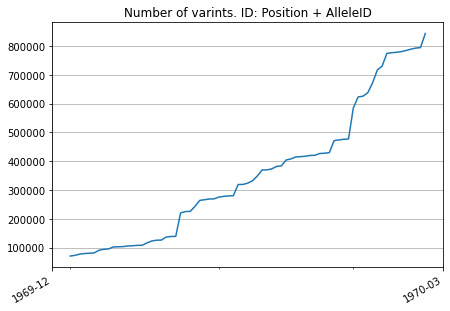

In [18]:
import matplotlib
#matplotlib.style.use('ggplot')

fig, ax = plt.subplots(figsize = (7,5))
ax.plot(st.index, st)
fmt_half_year = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.format_xdata = mdates.DateFormatter('%Y-%m')
#ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
ax.grid(True)

fig.autofmt_xdate()
title = 'Number of varints. ID: Position + AlleleID'
plt.title(title)
#plt.savefig('figures/'+ title + '.png')

plt.show()

In [234]:
import seaborn as sns
#sns.set_palette()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [32]:
import seaborn as sns

sns.set_palette(
sns.color_palette("deep"))


In [33]:
sns.color_palette("colorblind")[:7]

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236)]

In [34]:
colors = ['gold','olivedrab','green','brown','darkgrey',
         'darkseagreen','steelblue']
sns.set_palette(colors)
#colors = ['8DBACB','A7CAD6','FFFFFF','C2297A','BF2175']
#sns.set_palette(colors)


In [35]:
sns.color_palette("deep")


[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [92]:
allValuesNoConf = allValues.loc[allValues.index[~allValues.index.str.contains('Conflicting')],:]

In [93]:
allValuesNoConf

,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05
Benign-Pathogenic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,6.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
Benign-VUS,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,33.0,0.0,41.0,0.0,0.0,12.0,2.0,2.0,7.0,0.0,18.0,2.0,0.0,1.0,0.0,14.0,3.0,0.0,4.0,12.0,0.0,0.0,3.0,1.0,11.0,0.0,9.0,5.0,2.0,3.0,1.0,1.0,1.0,0.0,4.0,12.0,5.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,9.0,2.0,1.0,13.0,700.0,12.0,18.0,5.0,0.0,0.0,0.0,2.0,7.0,3.0,24.0,13.0,0.0,7.0,4.0,4.0,33.0,5.0,31.0,5.0,14.0,4.0,124.0,5.0,20.0,1.0,23.0,3.0,5.0,3.0,18.0,9.0,145.0,6.0,12.0,16.0,1.0
Pathogenic-Benign,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,1.0,0.0,19.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,1.0,0.0,21.0,3.0,2.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,76.0,10.0,0.0,0.0,2.0,19.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,3.0,1.0,0.0,11.0,16.0,0.0,0.0,10.0,3.0,13.0,0.0,1.0,1.0,2.0,20.0,21.0,2.0,2.0,0.0,0.0,1.0,6.0,2.0,9.0,1.0,1.0,1.0,1.0
Pathogenic-VUS,3.0,0.0,1.0,2.0,1.0,3.0,1.0,13.0,0.0,3.0,3.0,0.0,86.0,20.0,55.0,1.0,3.0,32.0,4.0,5.0,31.0,2.0,39.0,5.0,0.0,9.0,0.0,51.0,0.0,1.0,0.0,45.0,0.0,1.0,9.0,21.0,64.0,2.0,38.0,166.0,41.0,76.0,21.0,18.0,0.0,22.0,19.0,56.0,68.0,24.0,5.0,118.0,12.0,9.0,4.0,3.0,67.0,12.0,15.0,130.0,131.0,48.0,161.0,24.0,6.0,15.0,21.0,6.0,24.0,117.0,189.0,78.0,13.0,17.0,18.0,33.0,128.0,28.0,112.0,23.0,44.0,17.0,411.0,30.0,125.0,28.0,19.0,25.0,36.0,23.0,91.0,55.0,423.0,21.0,65.0,24.0,12.0
VUS-Benign,0.0,0.0,55.0,0.0,0.0,62.0,0.0,1.0,11.0,0.0,0.0,1.0,124.0,9.0,3.0,4.0,15.0,0.0,1.0,86.0,2.0,0.0,67.0,19.0,0.0,3.0,60.0,1.0,1.0,2.0,110.0,117.0,4.0,17.0,59.0,123.0,125.0,1.0,7.0,9.0,12.0,15.0,25.0,28.0,0.0,0.0,2.0,0.0,14.0,0.0,0.0,25.0,39.0,241.0,0.0,1051.0,31.0,18.0,45.0,291.0,3328.0,56.0,13.0,12.0,1.0,3.0,1.0,36.0,613.0,6.0,9.0,3.0,239.0,323.0,22.0,9.0,226.0,6.0,5.0,4.0,29.0,11.0,14.0,225.0,922.0,6.0,20.0,8.0,9.0,11.0,103.0,11.0,9512.0,465.0,334.0,26.0,0.0
VUS-Pathogenic,4.0,1.0,6.0,0.0,0.0,7.0,2.0,2.0,1.0,3.0,0.0,0.0,35.0,3.0,2.0,1.0,6.0,10.0,1.0,2.0,3.0,1.0,3.0,22.0,2.0,10.0,0.0,23.0,1.0,1.0,9.0,50.0,2.0,1.0,20.0,29.0,42.0,2.0,11.0,4.0,15.0,59.0,22.0,15.0,0.0,1.0,8.0,35.0,14.0,2.0,5.0,115.0,16.0,4.0,1.0,1.0,24.0,9.0,28.0,198.0,41.0,27.0,115.0,3.0,40.0,8.0,80.0,30.0,243.0,13.0,26.0,13.0,58.0,3.0,23.0,13.0,74.0,21.0,19.0,22.0,21.0,27.0,96.0,16.0,775.0,20.0,24.0,15.0,20.0,26.0,46.0,34.0,1585.0,82.0,72.0,29.0,17.0


In [154]:
allValuesNoConf.sum(axis = 0)

2015-05        7.0
2015-06        1.0
2015-07       63.0
2015-08        2.0
2015-09        1.0
2015-10       78.0
2015-11        4.0
2015-12       20.0
2016-01       13.0
2016-02        6.0
2016-03        3.0
2016-04        5.0
2016-05      281.0
2016-06       35.0
2016-07      108.0
2016-08        7.0
2016-09       24.0
2016-10       73.0
2016-11        8.0
2016-12       95.0
2017-01       43.0
2017-02        5.0
2017-03      129.0
2017-04       48.0
2017-05        3.0
2017-06       24.0
2017-07       60.0
2017-08       90.0
2017-09        5.0
2017-10        4.0
2017-11      123.0
2017-12      225.0
2018-01        7.0
2018-02       20.0
2018-03       92.0
2018-04      174.0
2018-05      246.0
2018-06        6.0
2018-07       65.0
2018-08      205.0
2018-09       73.0
2018-10      156.0
2018-11       71.0
2018-12       62.0
2019-01        1.0
2019-02       25.0
2019-03       34.0
2019-04      103.0
2019-05      101.0
2019-06       28.0
2019-07       12.0
2019-08      261.0
2019-09     

In [166]:
from datetime import datetime
def plotChnages(count, title,width = 30,ncol = 6):

    fig, ax = plt.subplots(figsize=(14,5))  
    N = count.shape[1]
    width = 0.35
    #r = list(range(count.shape[1]))
   # display(count)
    r = pd.to_datetime(count.columns)
    rest = []
    ind = count.sum(axis= 1).sort_values(ascending = True).index
    count  = count.loc[ind,]
    for i in count.index:
        ax.bar(r, count[count.index==i].values.squeeze(),bottom = count[count.index.isin(rest)].sum().values,
               width=28,label = i )
        rest.append(i)

    fmt_half_year = mdates.MonthLocator(interval=6)
    ax.xaxis.set_major_locator(fmt_half_year)
    fmt_month = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(fmt_month)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.format_xdata = mdates.DateFormatter('%Y-%m')
    ax.format_ydata = lambda x: f'${x:.2f}'  # Format the price.
   # plt.title(label = title)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=False, shadow=False, ncol=ncol)   
    plt.xlim(datetime(2015,6,1),datetime(2023,6,1))
    plt.ylim(0,2000)
    #plt.yscale('log')
  
    plt.tight_layout()
    plt.savefig('figuresNew/'+ title + '.png', dpi = 150)
    plt.show()

In [167]:
pd.crosstab(noisy['LabelOld'],noisy['LabelNew']).sum().sum()

34487

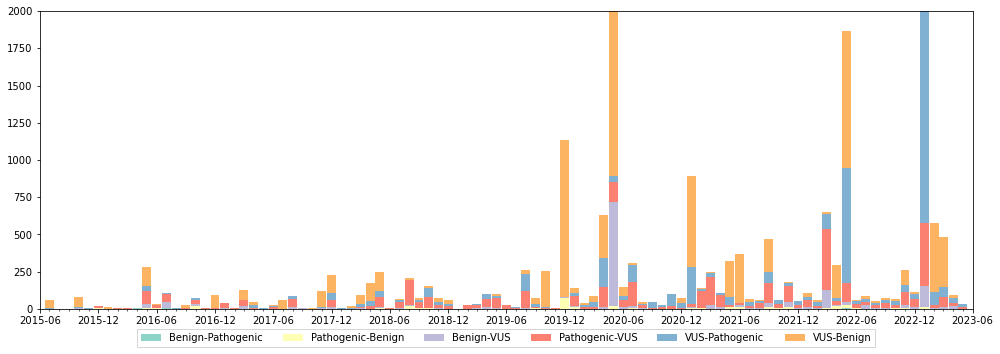

In [168]:
sns.set_palette(
sns.color_palette("Set3"))
plotChnages(allValuesNoConf,'ClinVarAbsChangesLim') #absolute


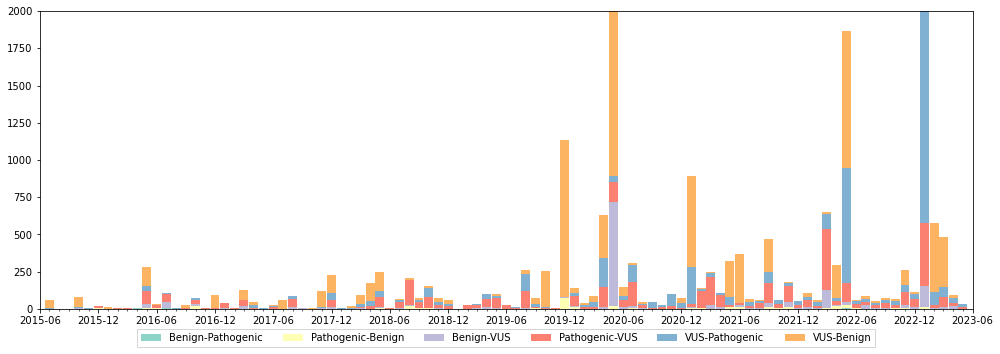

In [119]:
sns.set_palette(
sns.color_palette("Set3"))
plotChnages(allValuesNoConf,'ClinVarAbsChangesLim') #absolute


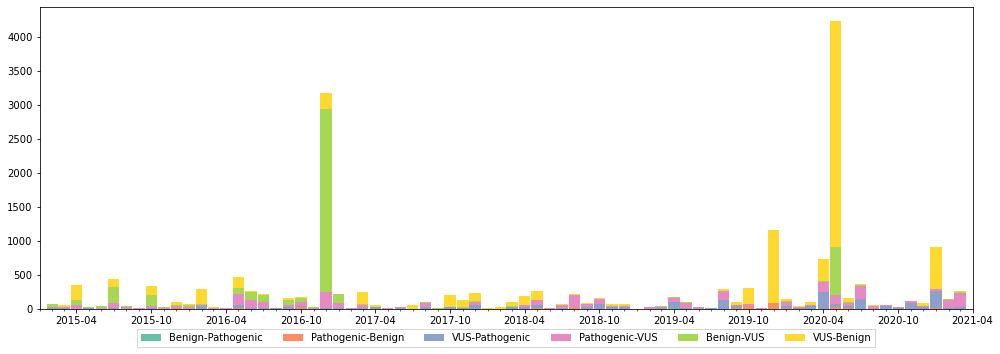

In [216]:
plotChnages(allValuesNoConf,'Absolute changes in the labels with respect to the previous month in ClinVar dataset') #absolute


In [136]:
#plotChnages(allValues,'Delta of CS wrt to the previous month') #absolute

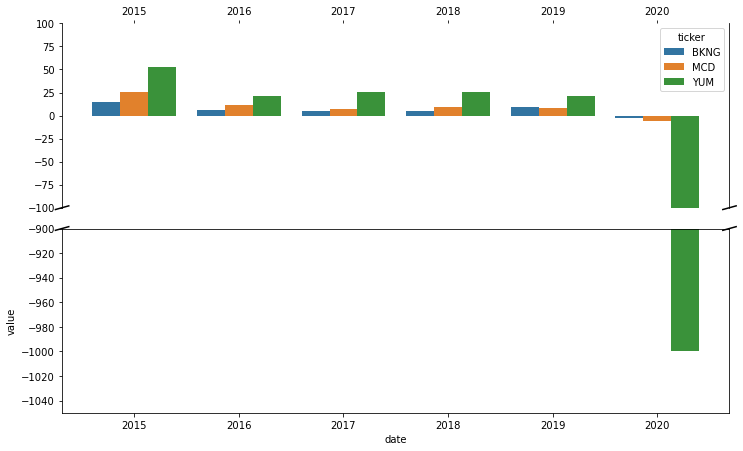

In [149]:
import seaborn as sns
dict_ = {'date': [pd.Timestamp('20150720'),pd.Timestamp('20160720'),pd.Timestamp('20170720'),pd.Timestamp('20180720'),pd.Timestamp('20190720'),pd.Timestamp('20200720')],
            'BKNG': [15.22, 6.36, 5.05, 5, 9.3641, -3],
            'MCD' : [25.22, 11.36, 7.05, 9, 8.3641, -6],
            'YUM' : [52.22, 21.36, 25.05, 26, 21.3641, -1000]
    
}

df = pd.DataFrame(dict_)
df['date'] = df['date'].dt.year

df = df.set_index('date').stack().reset_index()
df.columns = ['date','ticker','value']


f, ax = plt.subplots(2, 1, sharex=True, figsize=(10,6))
f.tight_layout()
# plot the same data on both axes
sns.barplot(x='date',y='value',hue='ticker',data=df, ax=ax[0], )
ax[0].set_ylim(-100,100)
sns.barplot(x='date',y='value',hue='ticker',data=df, ax=ax[1])
ax[1].set_ylim(-1050,-900)

ax[0].spines['bottom'].set_visible(False)
ax[0].set(xlabel='', ylabel='')
ax[0].spines['top'].set_visible(False)
ax[0].xaxis.tick_top()
ax[0].tick_params(labeltop='off')  # don't put tick labels at the top
ax[1].xaxis.tick_bottom()
ax[1].legend([],[], frameon=False)
d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
ax[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

plt.show()

In [226]:
def plotChnages(count, title,width = 30,ncol = 6):

    fig, ax = plt.subplots(2, 1, sharex=True,figsize=(14,10))  
    fig.tight_layout()

    N = count.shape[1]
    width = 0.35
    #r = list(range(count.shape[1]))
   # display(count)
    r = pd.to_datetime(count.columns)
    rest = []
    ax[1].set_ylim(0,700)
    ax[0].set_ylim(1100,1200)
    for i in count.index[:]:
        ax[1].bar(r, count[count.index==i].values.squeeze(),bottom = count[count.index.isin(rest)].sum().values,
               width=27,label = i )
        rest.append(i)
        
    for i in count.index[:]:
        ax[0].bar(r, count[count.index==i].values.squeeze(),bottom = count[count.index.isin(rest)].sum().values,
               width=27,label = i )
        rest.append(i)


    fmt_half_year = mdates.MonthLocator(interval=6)
    ax[0].xaxis.set_major_locator(fmt_half_year)
    fmt_month = mdates.MonthLocator()
    ax[0].xaxis.set_minor_locator(fmt_month)

    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax[0].format_xdata = mdates.DateFormatter('%Y-%m')
    ax[0].format_ydata = lambda x: f'${x:.2f}'  # Format the price.
    #plt.title(label = title)
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=False, shadow=False, ncol=ncol)   
    ax[0].legend([],[], frameon=False)
    d = .001  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
   

    kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
    ax[0].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax[0].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    ax[1].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax[1].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

   # plt.ylim(0, 250)
 #   plt.yscale('log')
  
    plt.tight_layout()
     #   plt.savefig('figures/'+ title + '.png', dpi = 350)
    plt.show()

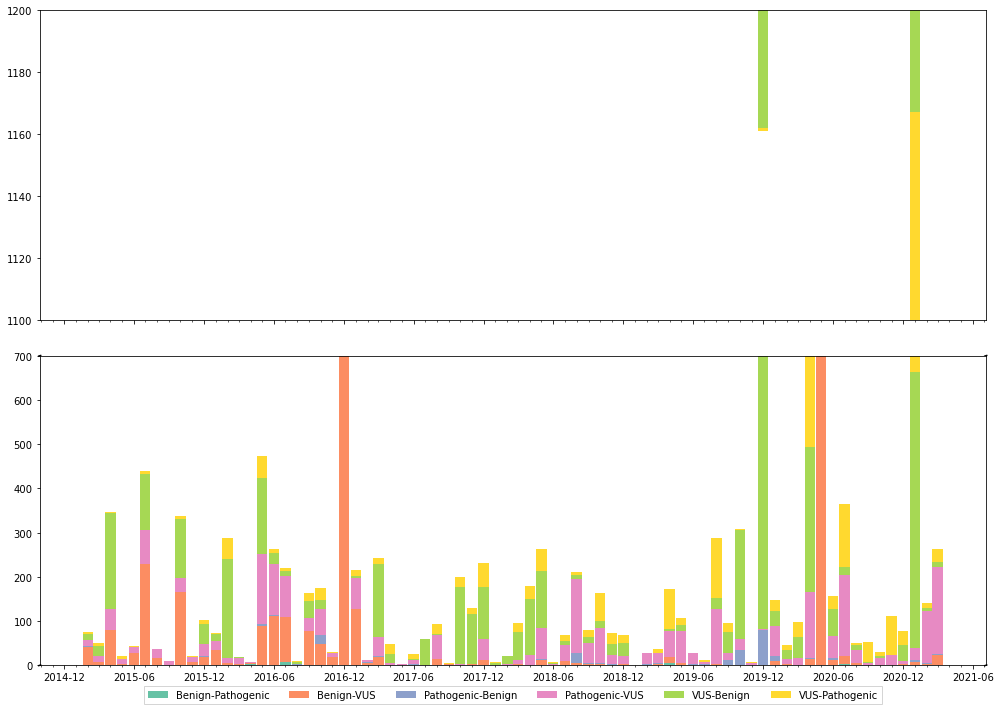

In [227]:
plotChnages(allValuesNoConf,'Absolute changes in the labels with respect to the previous month in ClinVar dataset') #absolute




In [ ]:
len(allValuesSample)
allCountSample

In [ ]:
plotChnages(allValuesRel,'Delta of CS wrt to the previous month',35) #relative

In [ ]:
plotChnages(allValuesSampleRel,'Delta of CS wrt to the previous month',35) #relative

In [ ]:
plotChnages(count,'Value count of CF per month',30,ncol=4)

In [ ]:
plotChnages(countSample,'Value count of CF per month',30,ncol=4)

In [ ]:
countSample.iloc[:,0]

In [ ]:
countSample.iloc[:,-1]

In [ ]:
#figure = plt.sublots()

#pd.Series(sing).plot(kind = 'bar',figsize = (10,7),stacked=False,colormap = 'viridis')

#### Quantife the CS

In [ ]:
to_replace = {'Uncertain significance': 0, 
              'Pathogenic': -1, 
              'Likely benign': 0.5, 
              'Benign': 1, 
              'Benign/Likely benign' : 0.75, 
              'Likely pathogenic' : -0.5, 
              'Pathogenic/Likely pathogenic' : -0.75}

ff = f.apply(lambda x: x.replace(to_replace))

In [ ]:
changed = []
for i in range(11):
    #c = (f[i]!=f[i+1]).sum()
    c = ((abs(ff[i]-ff[i+1]))>=0.5).sum()
    changed.append(c)

### Aside (use vcf files of ClinVar)

In [ ]:
import vcf 
import allel


In [ ]:
reader = vcf.Reader(open('dataRaw/clinvar_20150106.vcf', 'r'))

formats = reader.formats.keys()
infos = reader.infos.keys()
formats

In [ ]:
infos